In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import polars as ps
import pandas as pd
import scipy as sp
import json


In [2]:
def modelo_2rc(t, v0, v1, v2, t1, t2):
    return v0 + v1 * np.exp(-t * t1) + v2 * np.exp(-t * t2)


In [3]:
def get_t_v(p1, df):
    p1, p2 = p1, p1 + 200
    corrente = df["Corrente [A]"][p1 - 1]
    v_zp1 = df["Tensão [V]"][p1 - 1]
    df_teste = df[p1:p2][["Tempo [s]", "Tensão [V]"]].clone()
    df_teste = df_teste.select(
        [ps.col("Tempo [s]").alias("t"), ps.col("Tensão [V]").alias("v")]
    )

    vmin = df_teste["v"].min()
    vmax = df_teste["v"].max()
    t0 = df_teste["t"][0]
    df_teste["t"] = df_teste["t"] - df_teste["t"][0]
    df_teste["v"] = df_teste["v"] - df_teste["v"][0]

    t = df_teste["t"].to_numpy()
    v = df_teste["v"].to_numpy()
    return t, v, corrente, vmin, vmax, v_zp1, t0


In [4]:
def gerar_coeficientes_e_graficos(points, I, bounds, coeficientes, p0, df_c100):
    coeficientes[I] = dict()
    for i, p1 in enumerate(points[I]):
        t, v, corrente, vmin, vmax, v_r0, t0 = get_t_v(p1, df_c100)

        # Faz o fitting da curva
        vals, cov = sp.optimize.curve_fit(
            f=modelo_2rc, xdata=t, ydata=v, p0=p0, maxfev=30000, bounds=bounds
        )
        p0 = vals + np.random.normal(
            0, 0.001, 5
        )  # usa os valores atuais como o chute inicial para o próximo ponto

        v0 = vals[0]
        v1 = vals[1]
        v2 = vals[2]
        tau1 = (
            1 / vals[3]
        )  # A otimização funciona melhor utilizando exp(t*x) ao invés de exp(t/x)
        tau2 = (
            1 / vals[4]
        )  # A otimização funciona melhor utilizando exp(t*x) ao invés de exp(t/x)

        r0 = -(vmin - v_r0) / corrente
        r1 = v1 / corrente
        r2 = v2 / corrente
        c1 = tau1 * corrente / v1
        c2 = tau2 * corrente / v2
        coeficientes[I][f"{p1}"] = [
            v0,
            v1,
            v2,
            tau1,
            tau2,
            r0,
            r1,
            r2,
            c1,
            c2,
            vmin,
            vmax,
            v_r0,
            t0,
        ]

        title = f"""Curva {i}: {corrente:.0f} A
{vmax} v_max, {vmin} v_min, {vmax-vmin:.5e} ΔV
{v_r0} v_r0, {r0:.5e} r0
{v0:.3e} v0, {v1:.3e} v1, {v2:.5e} v2
{tau1:.3e} t1, {r1:.3e} r1, {c1:.3e} c1
{tau2:.3e} t2, {r2:.3e} r2, {c2:.3e} c2 
                """
        plt.figure(figsize=(20, 10))
        plt.title(title, loc="left")
        sns.scatterplot(y=v, x=t, color="red")
        sns.lineplot(y=modelo_2rc(t, *vals), x=t)
        plt.grid()
        plt.show()
        plt.close()

    return coeficientes


In [5]:
WS = pd.read_excel("./Dados_C100_patricio.xlsx")
df_c100 = ps.DataFrame(WS)

# pontos iniciais
points = {
    "100A": [36, 17299, 34586, 51912, 69298, 86728, 104172, 121666, 139361, 157114],
    "28A": [4483, 21738, 39026, 56352, 73738, 91168, 108612, 126106, 143801, 161554],
    "3A": [2267, 19523, 36810, 54136, 71522, 88952, 106396, 123890, 141585, 159338],
}

# Coeficientes de cada curva
coeficientes = dict()

# chute inicial: v0, v1, v2, 1/tau1, 1/tau2
p0 = np.array(
    [3.2247626343e-02, -2.11580237e-02, -9.80514235e-03, 3.18578442e-02, 2.12246228e-03]
) + np.random.normal(0, 0.001, 5)

# Limites para os valores dos coeficientes
bounds = ([-1, -100, -100, -1, -1], [100, 1, 1, np.inf, np.inf])


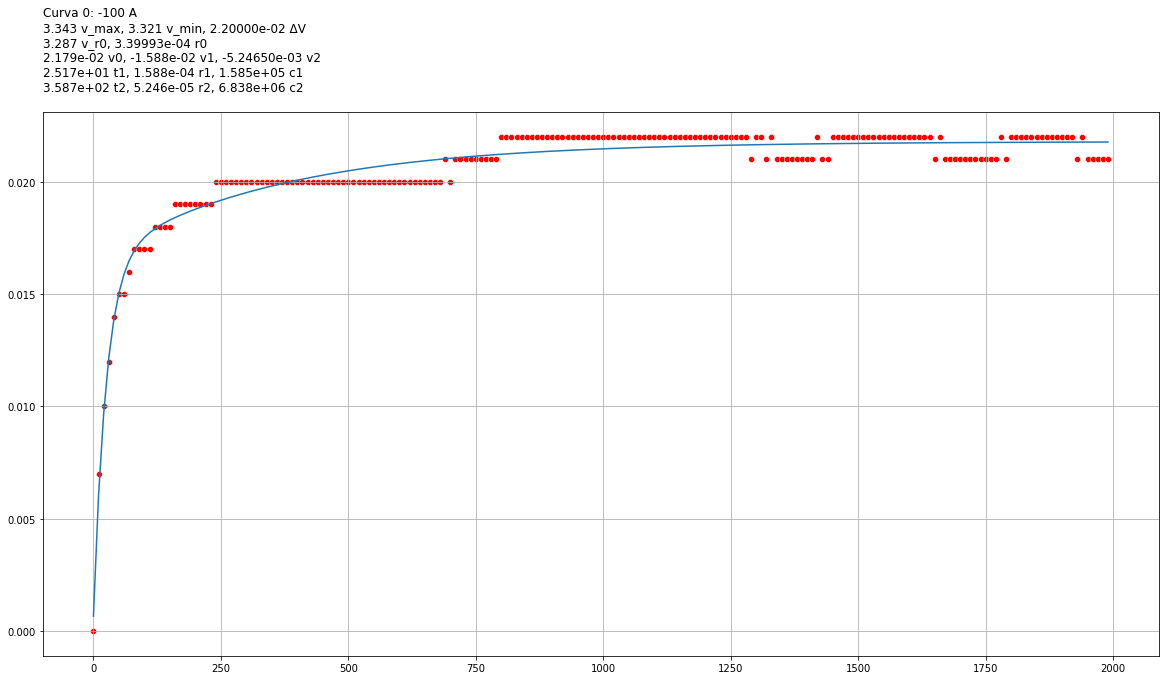

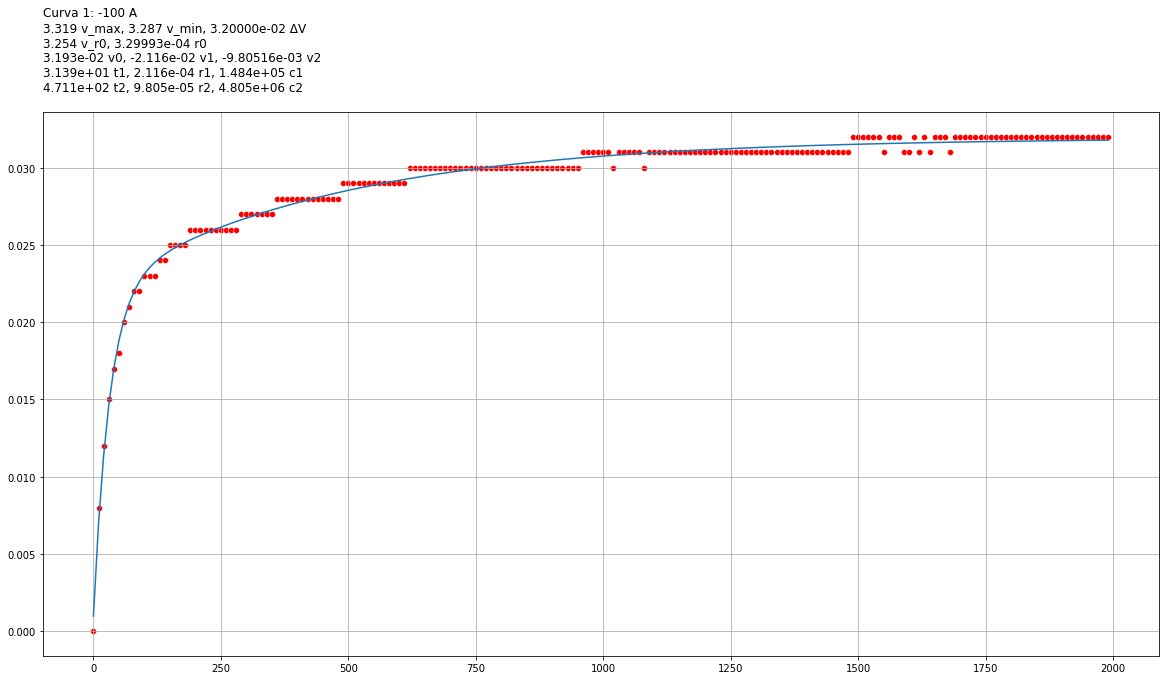

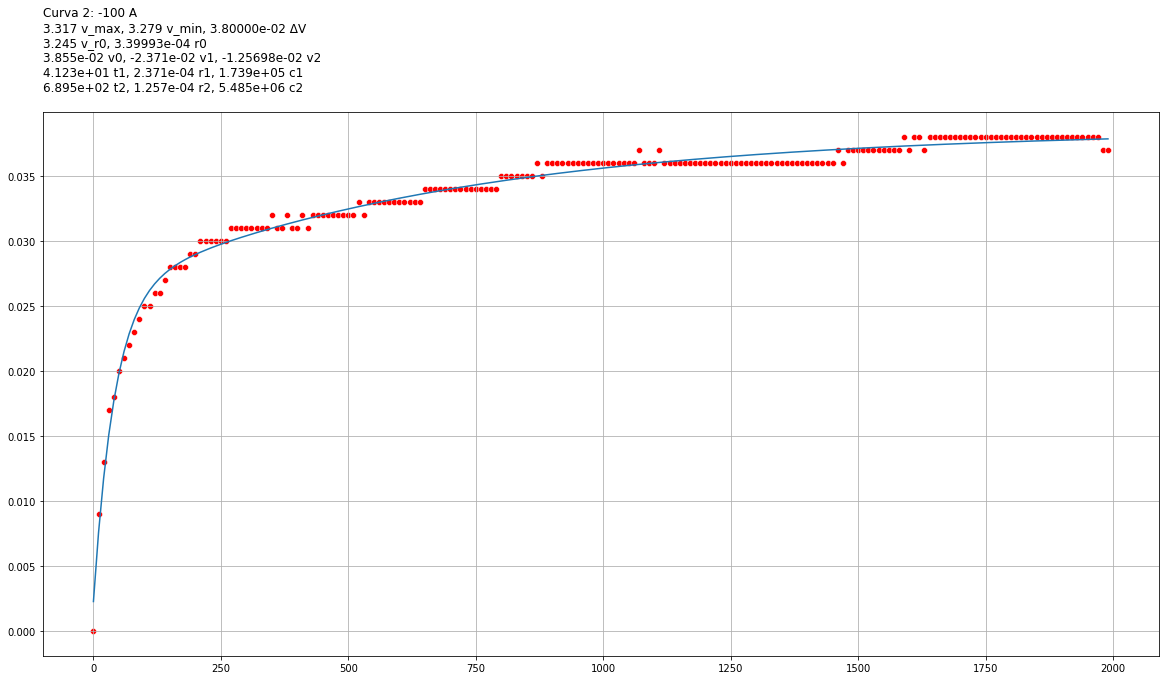

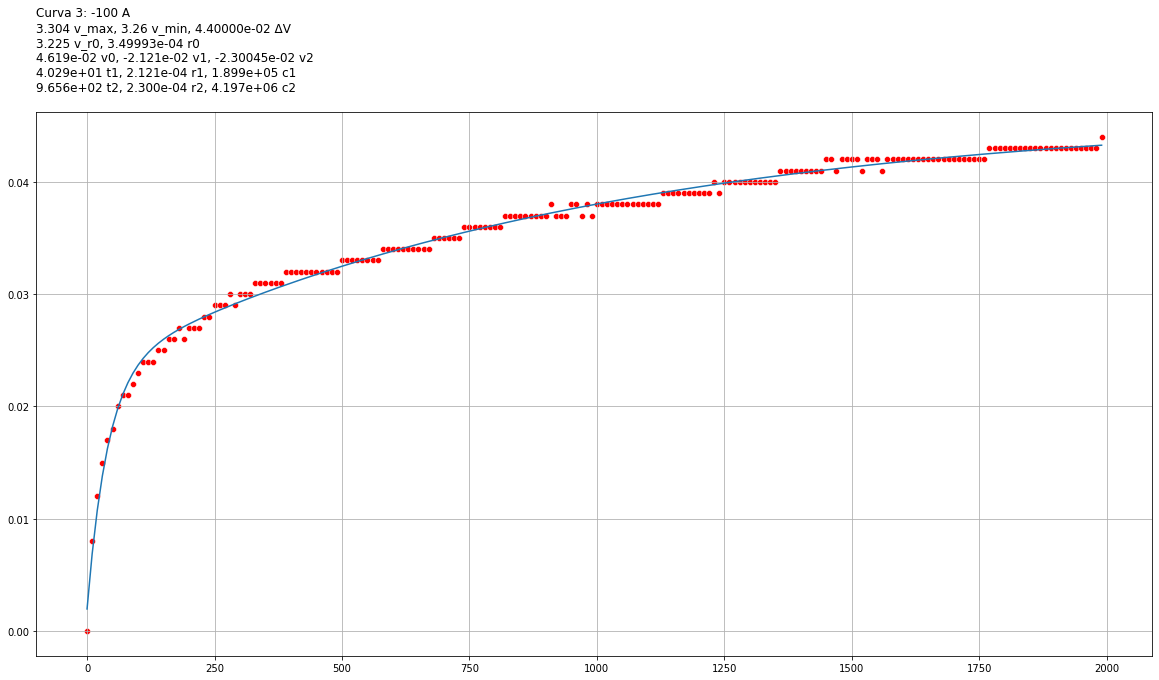

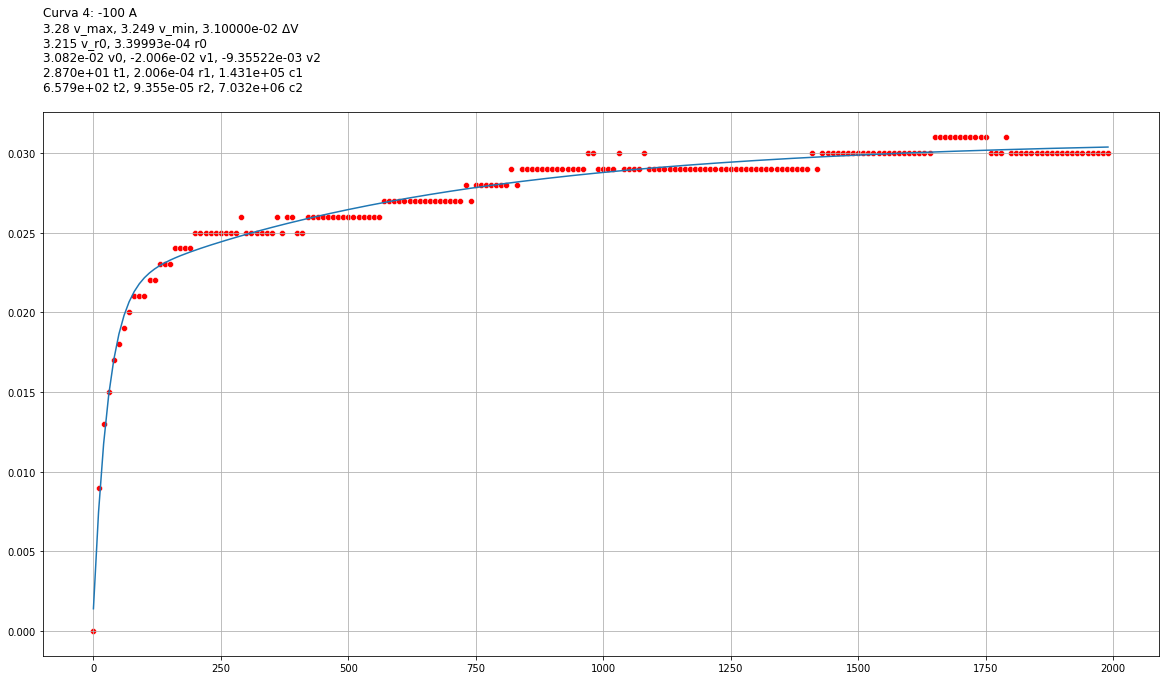

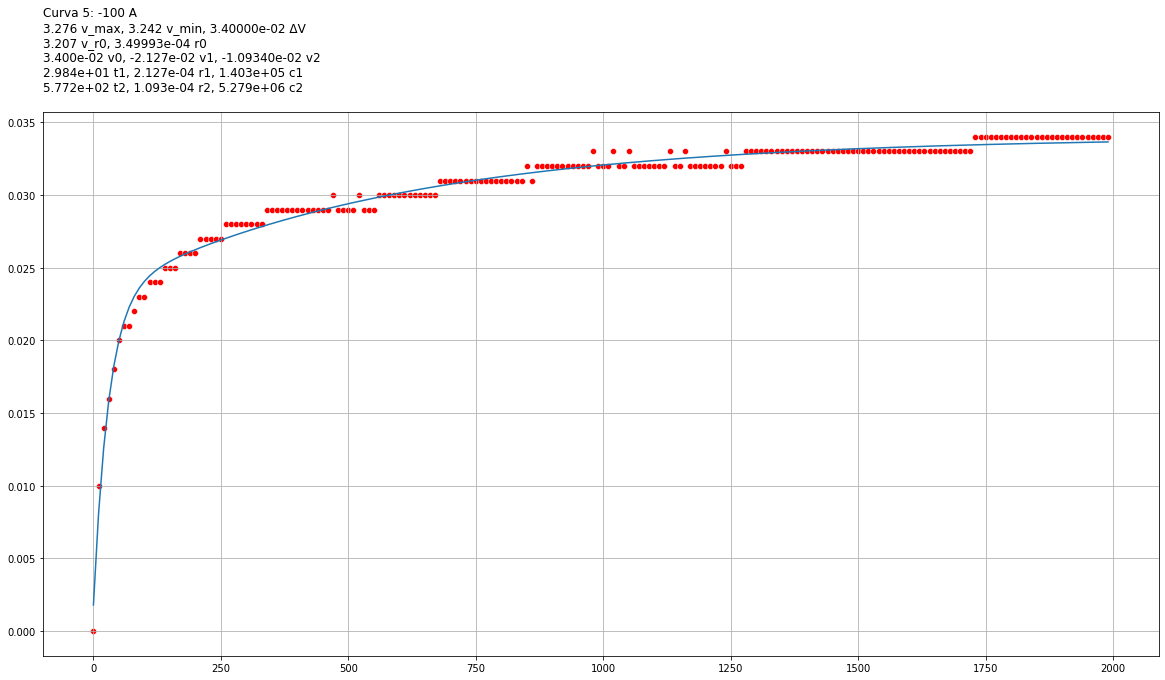

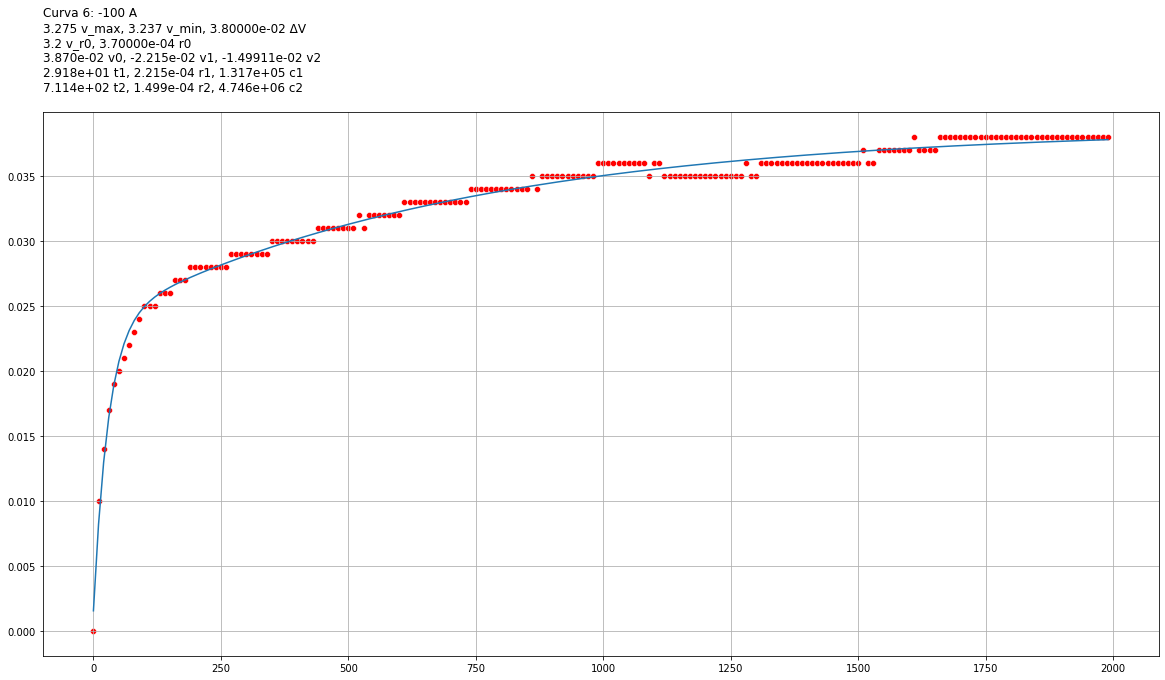

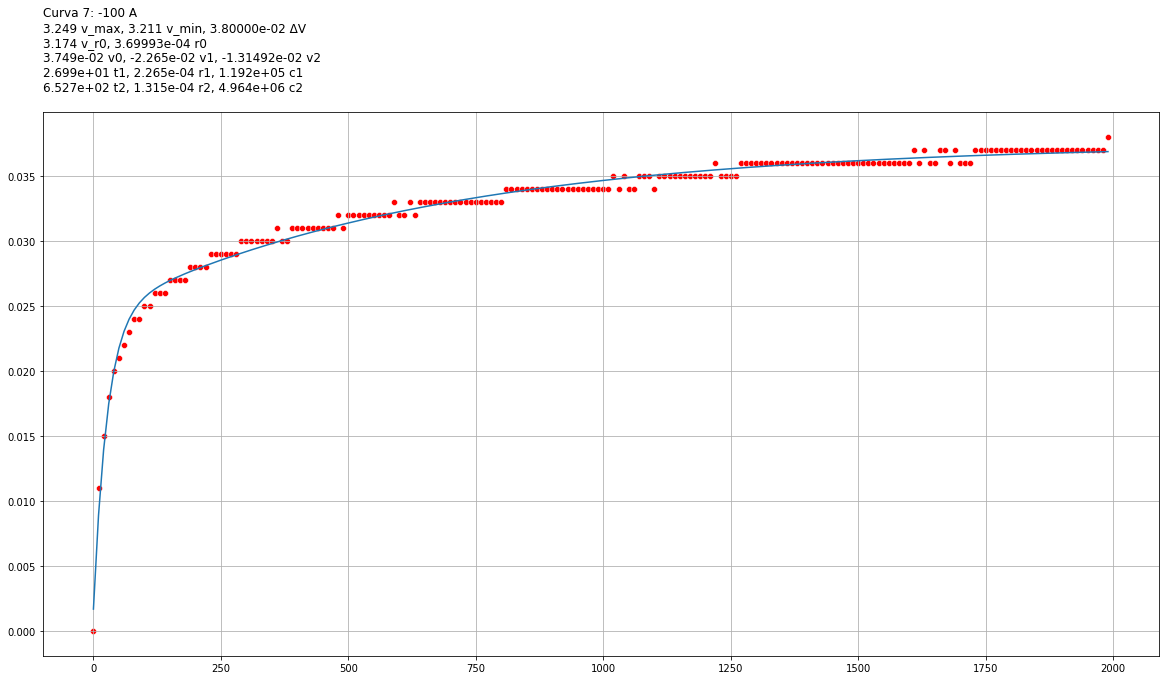

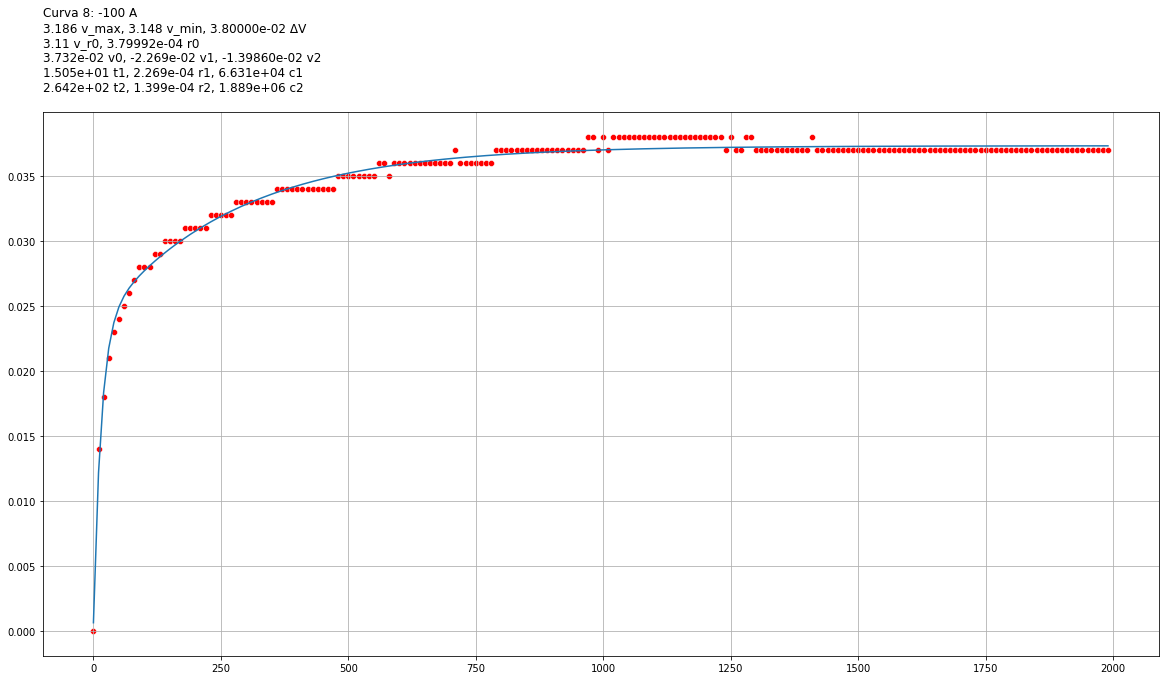

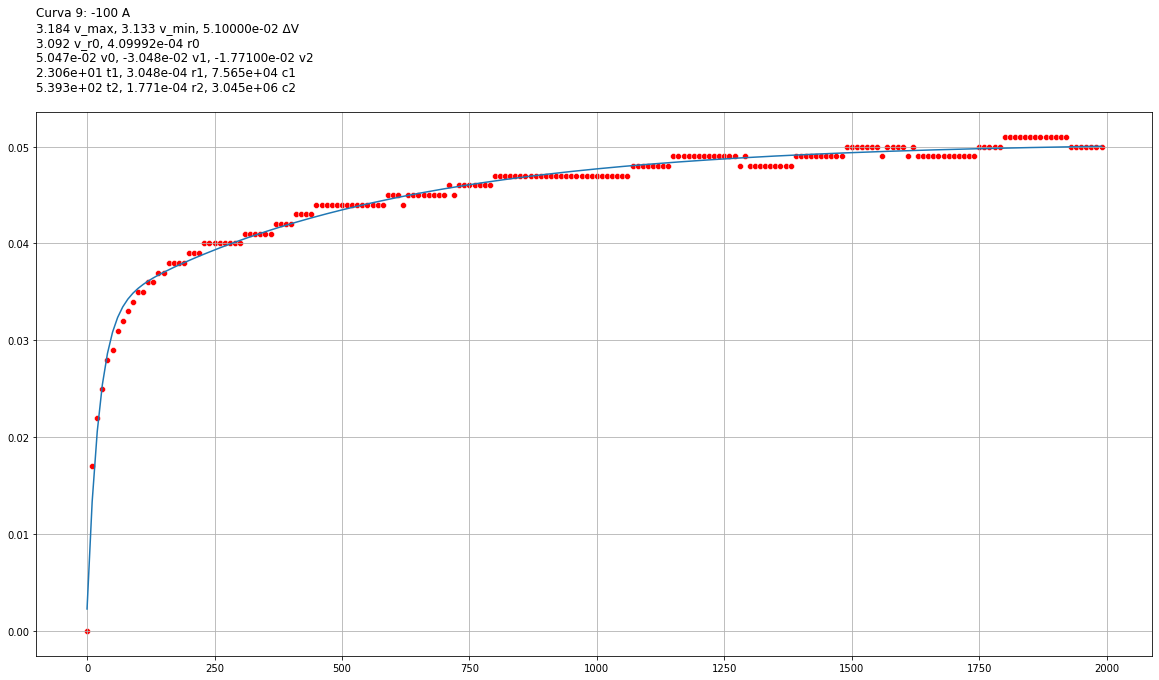

In [6]:
I = "100A"
coeficientes = gerar_coeficientes_e_graficos(
    points, I, bounds, coeficientes, p0, df_c100
)


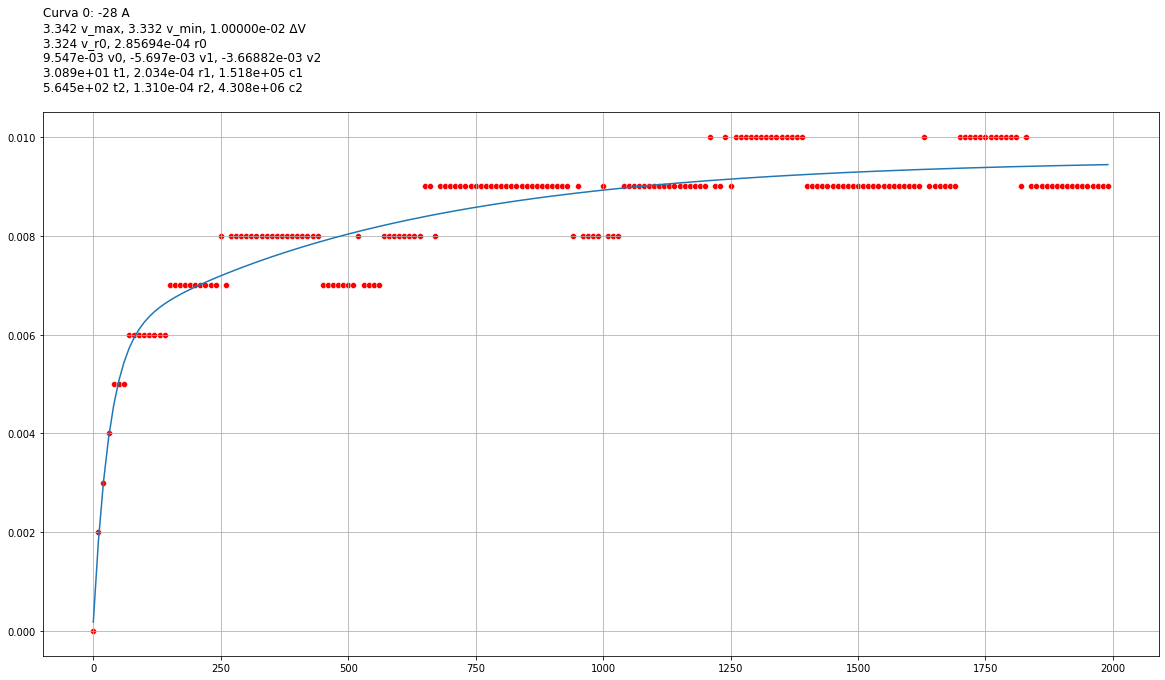

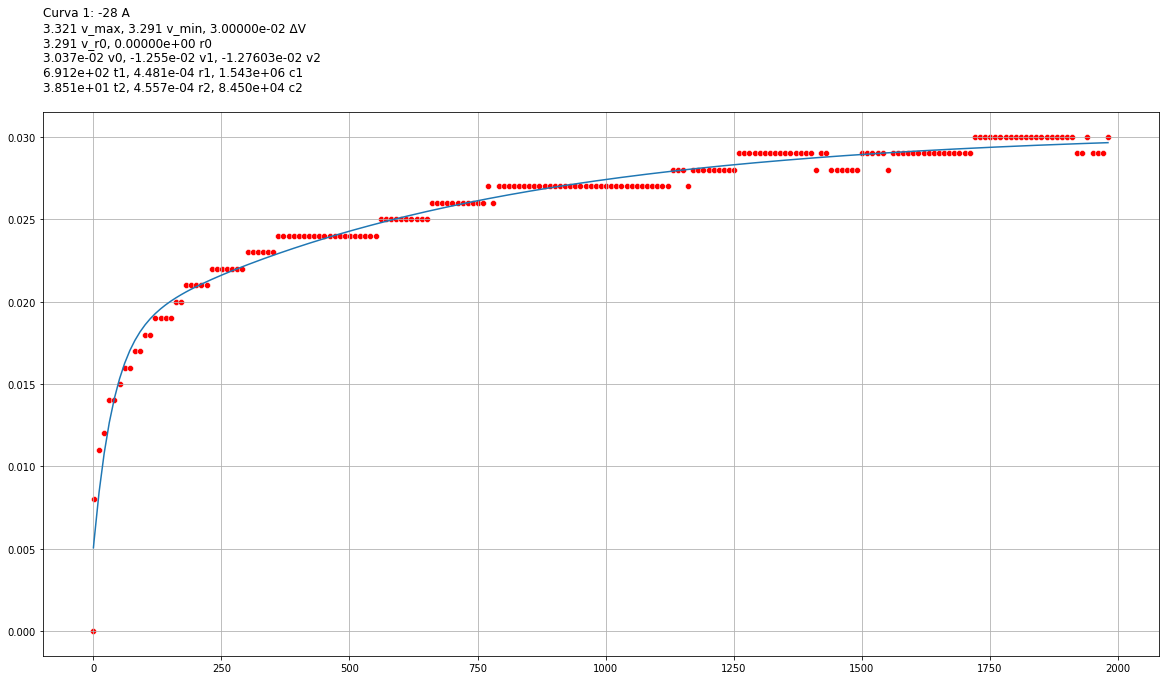

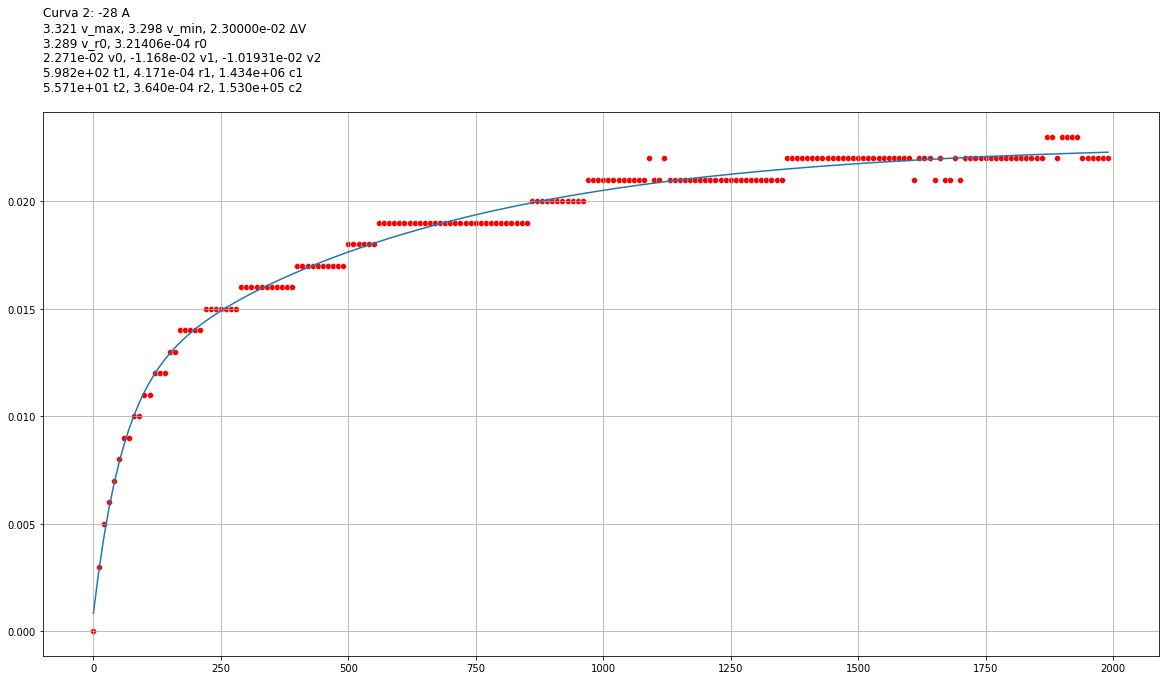

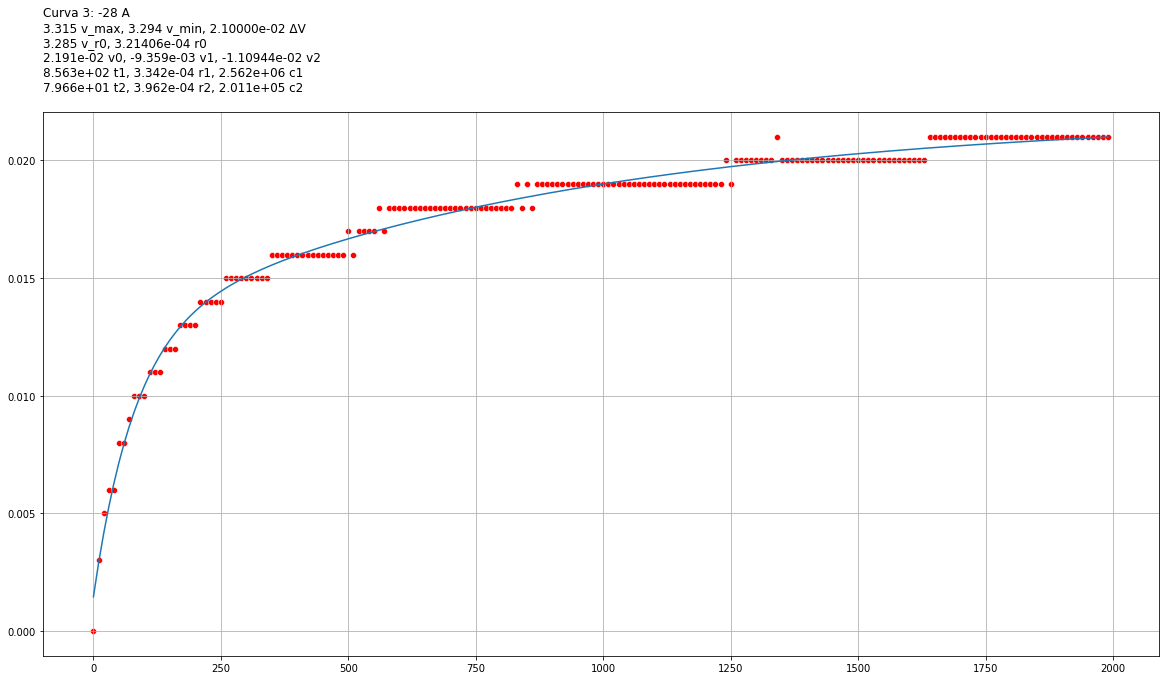

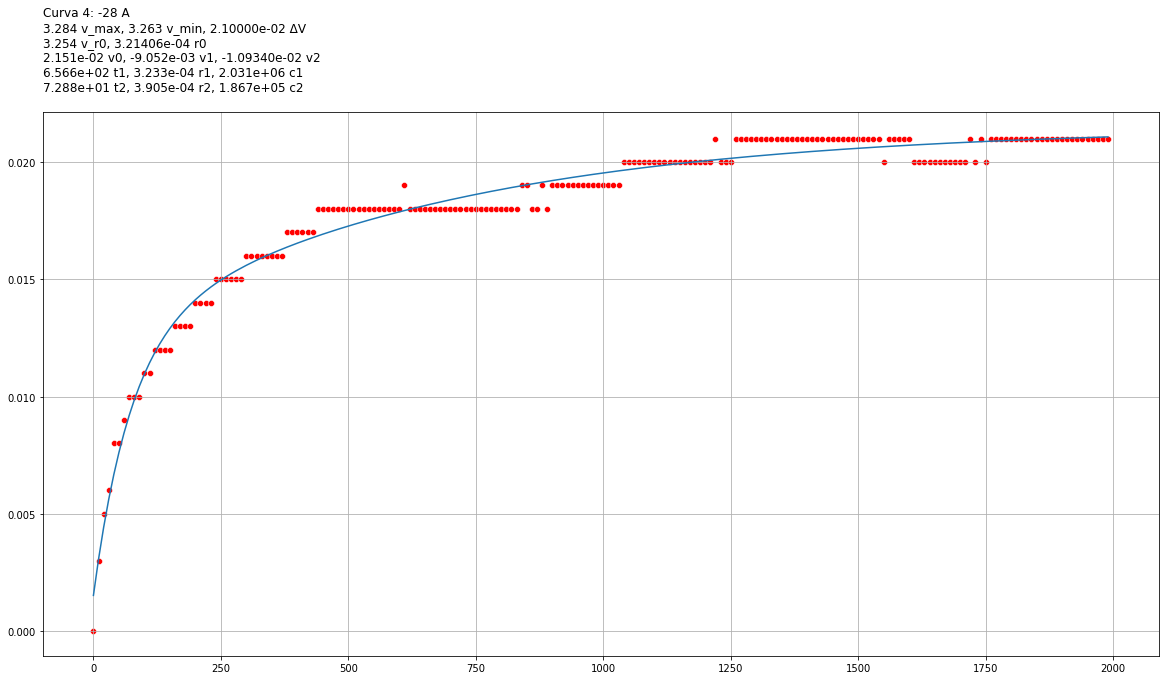

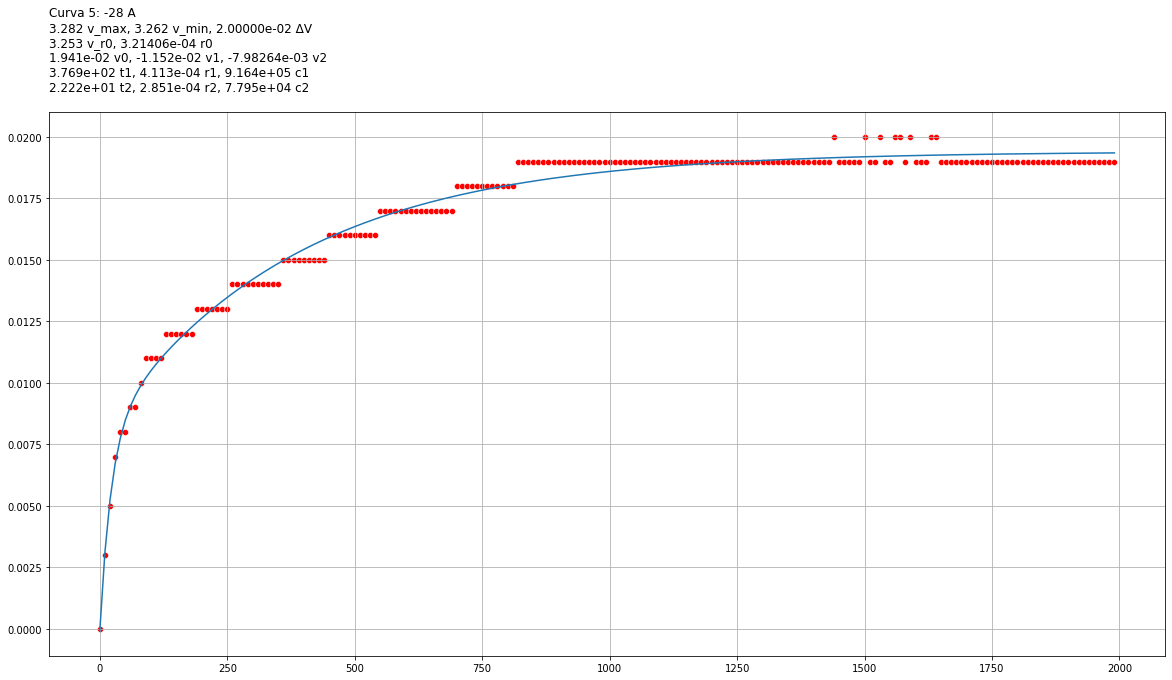

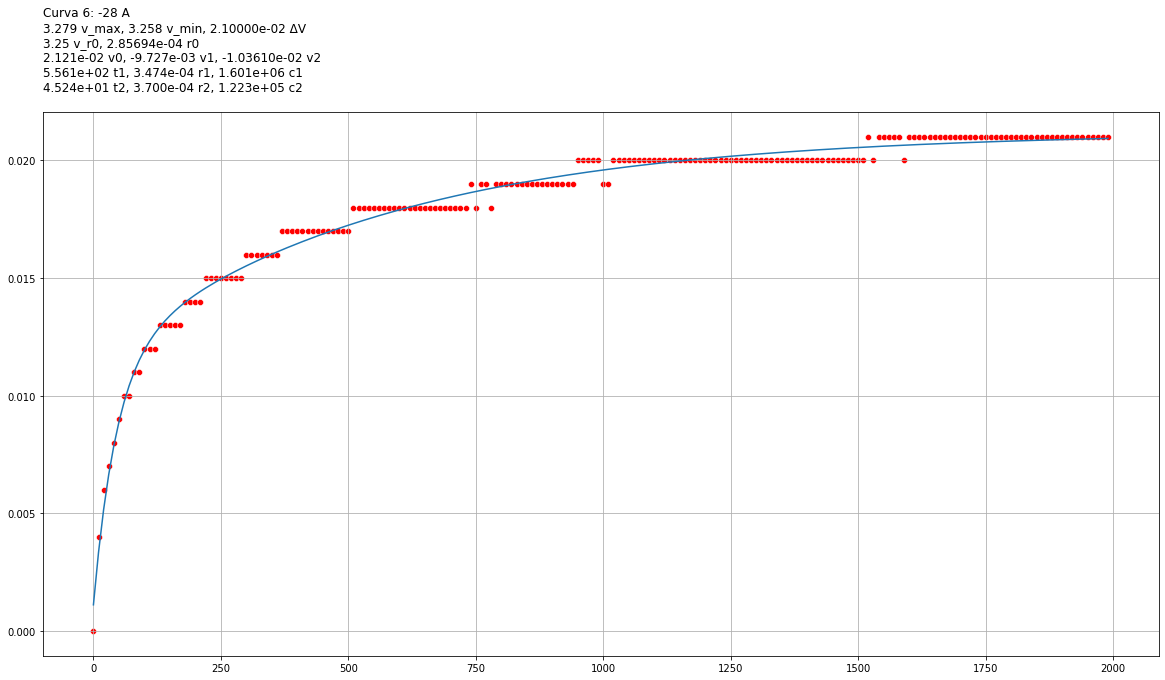

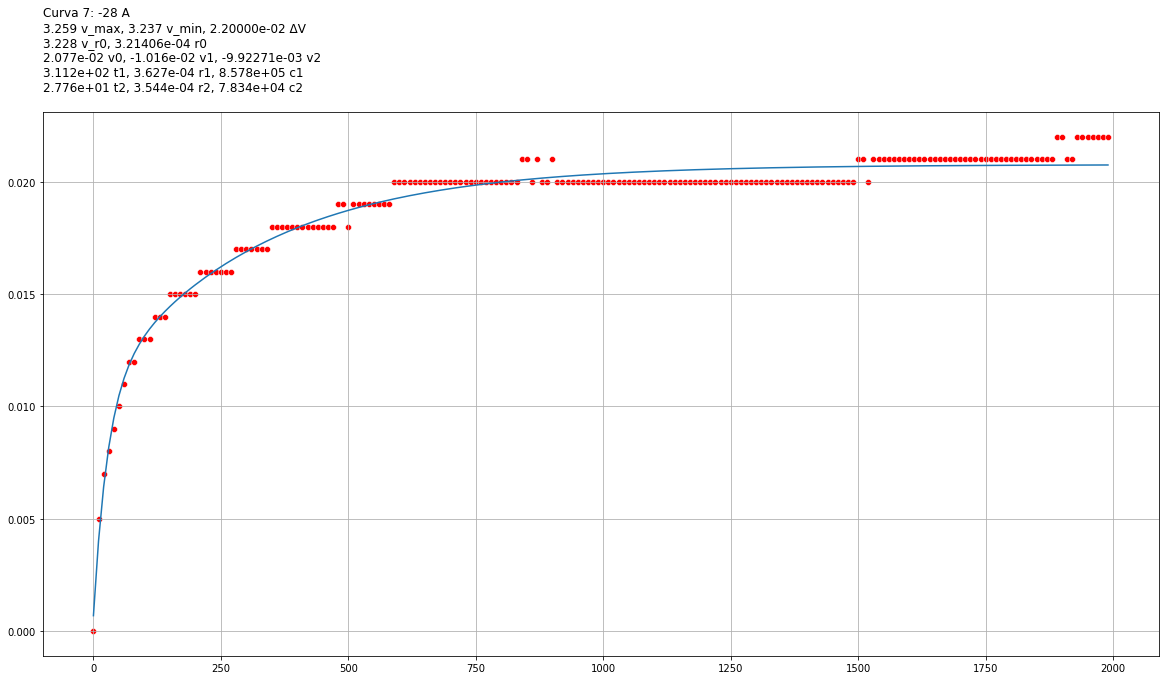

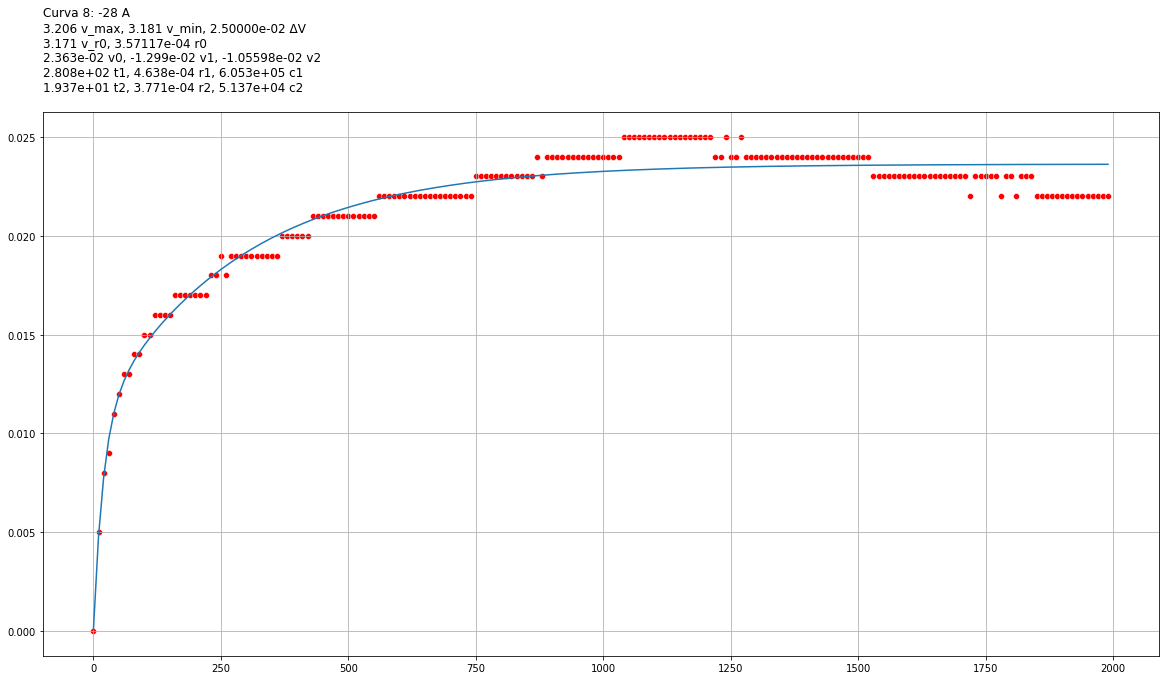

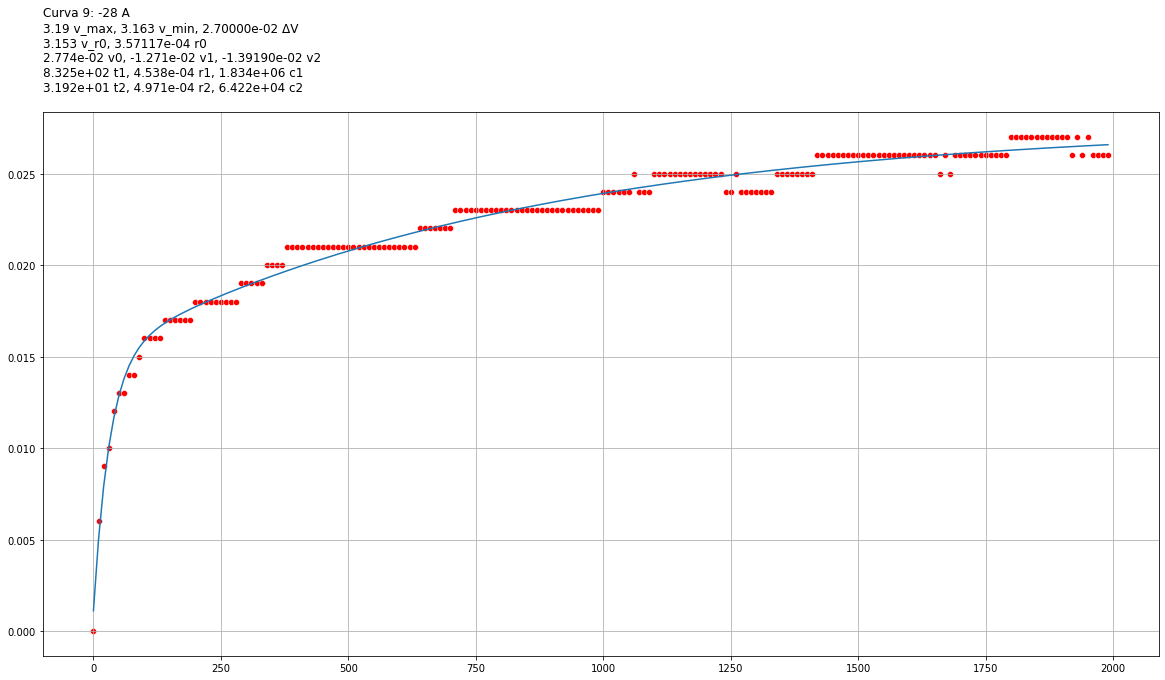

In [8]:
I = "28A"
coeficientes = gerar_coeficientes_e_graficos(
    points, I, bounds, coeficientes, p0, df_c100
)


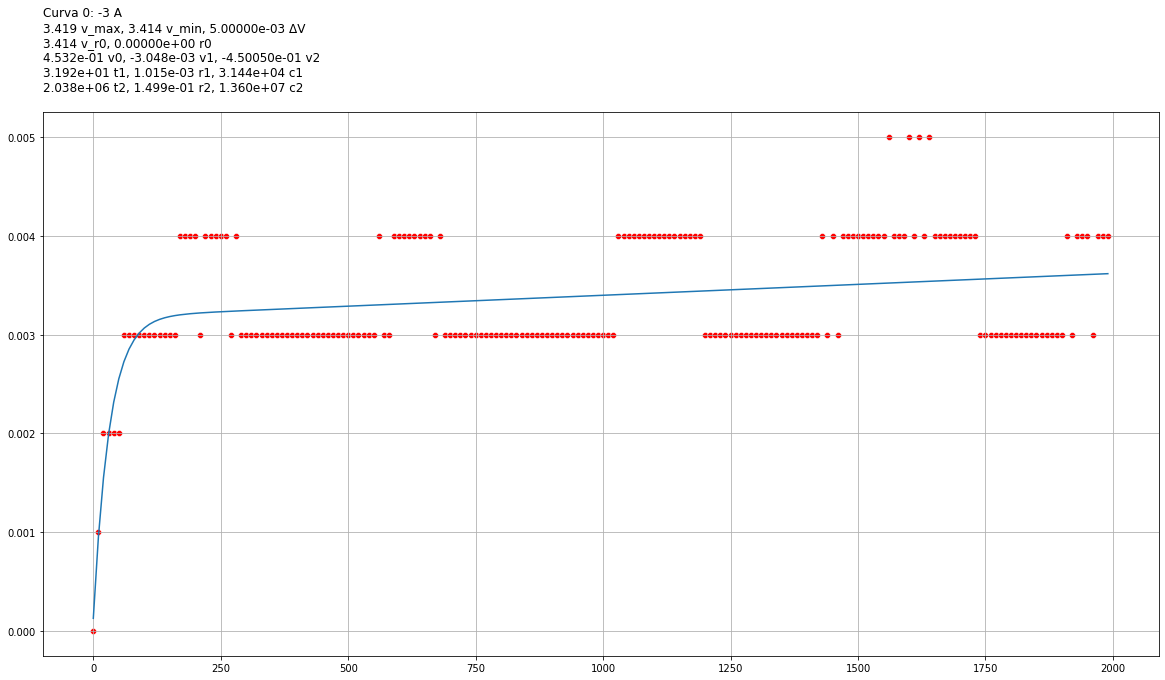

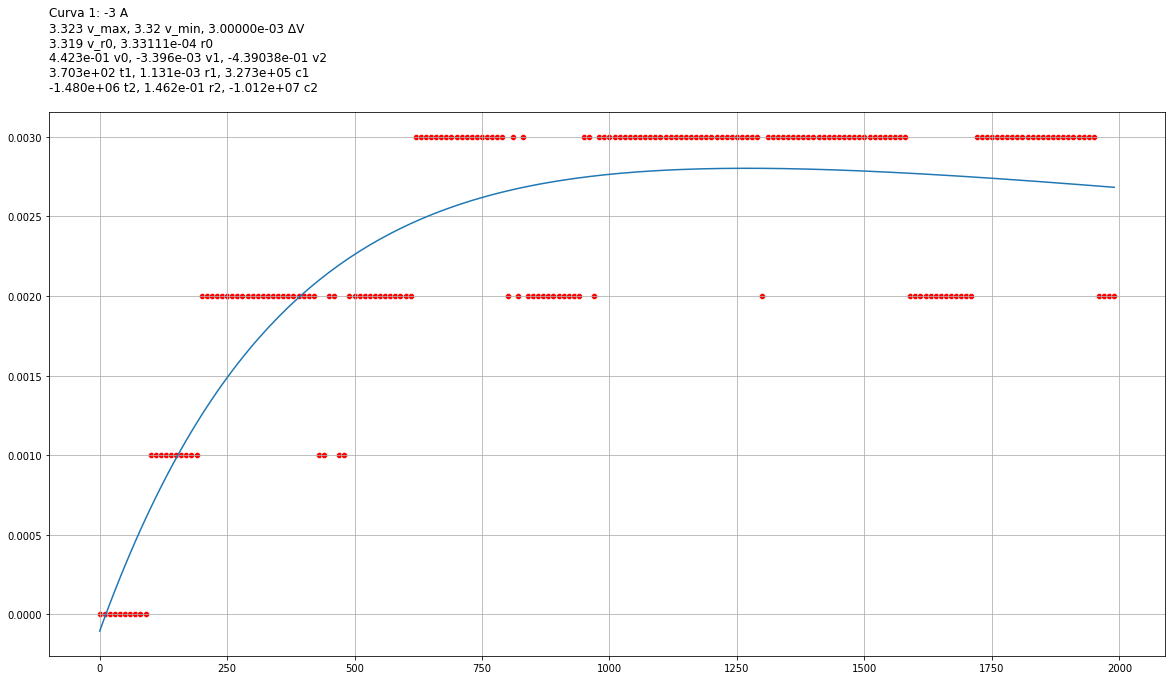

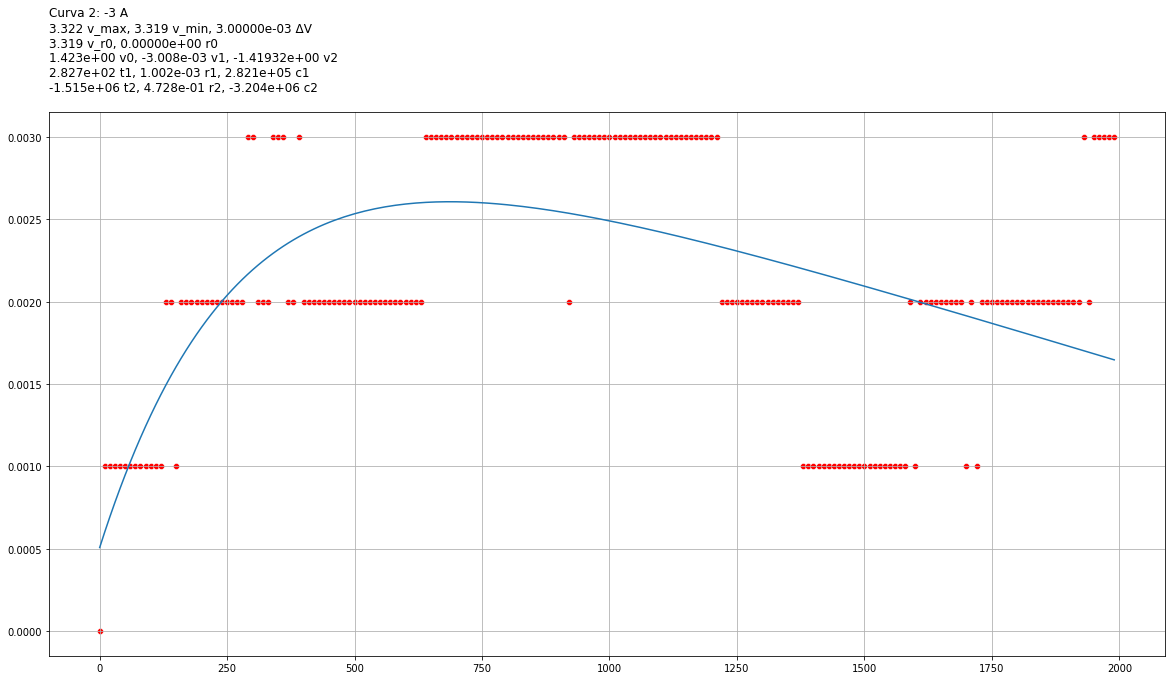

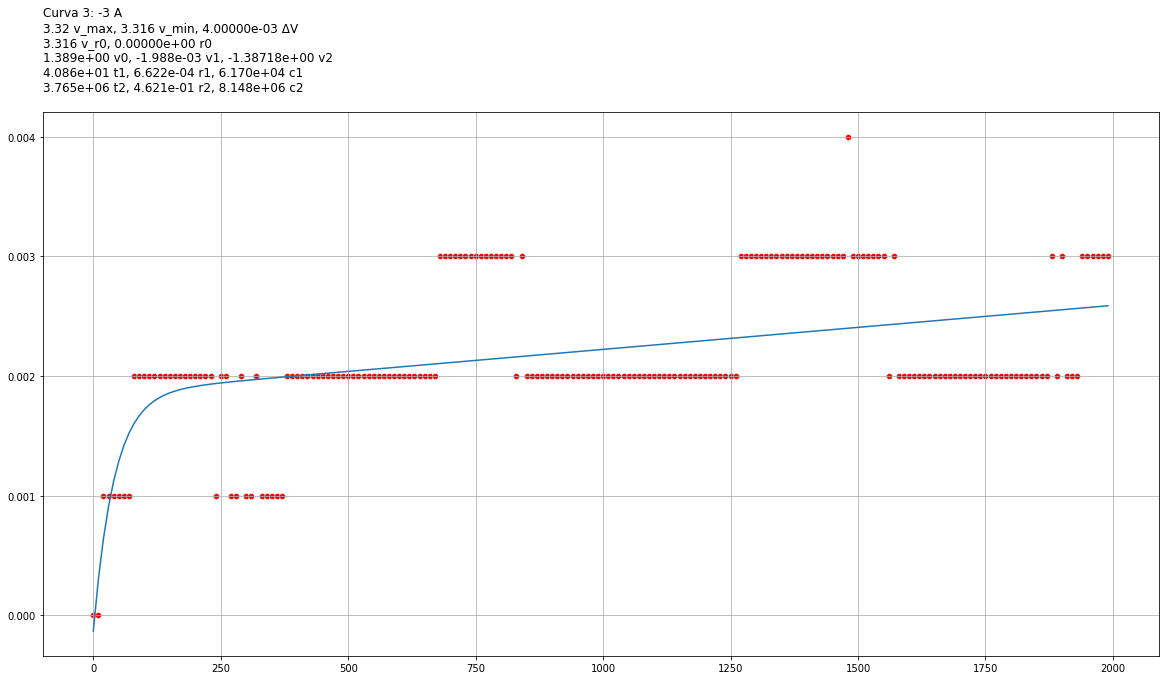

/tmp/ipykernel_1687/2759462548.py:2: RuntimeWarning: overflow encountered in exp
  return v0+v1*np.exp(-t*t1)+v2*np.exp(-t*t2)


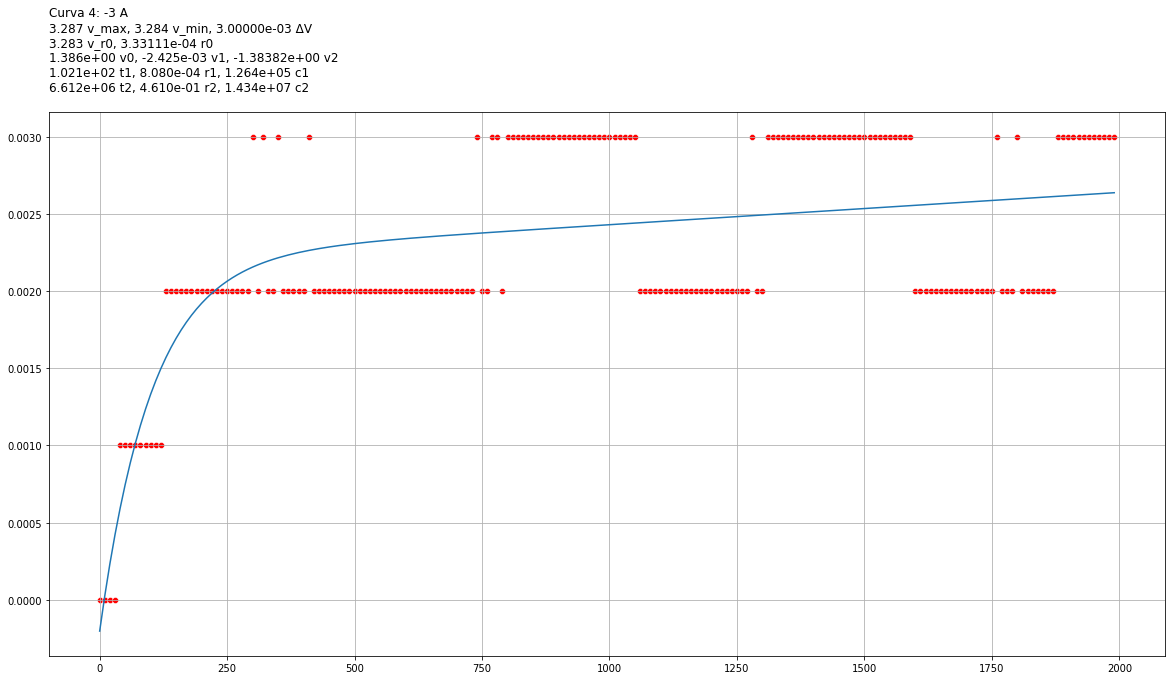

/tmp/ipykernel_1687/2759462548.py:2: RuntimeWarning: overflow encountered in exp
  return v0+v1*np.exp(-t*t1)+v2*np.exp(-t*t2)


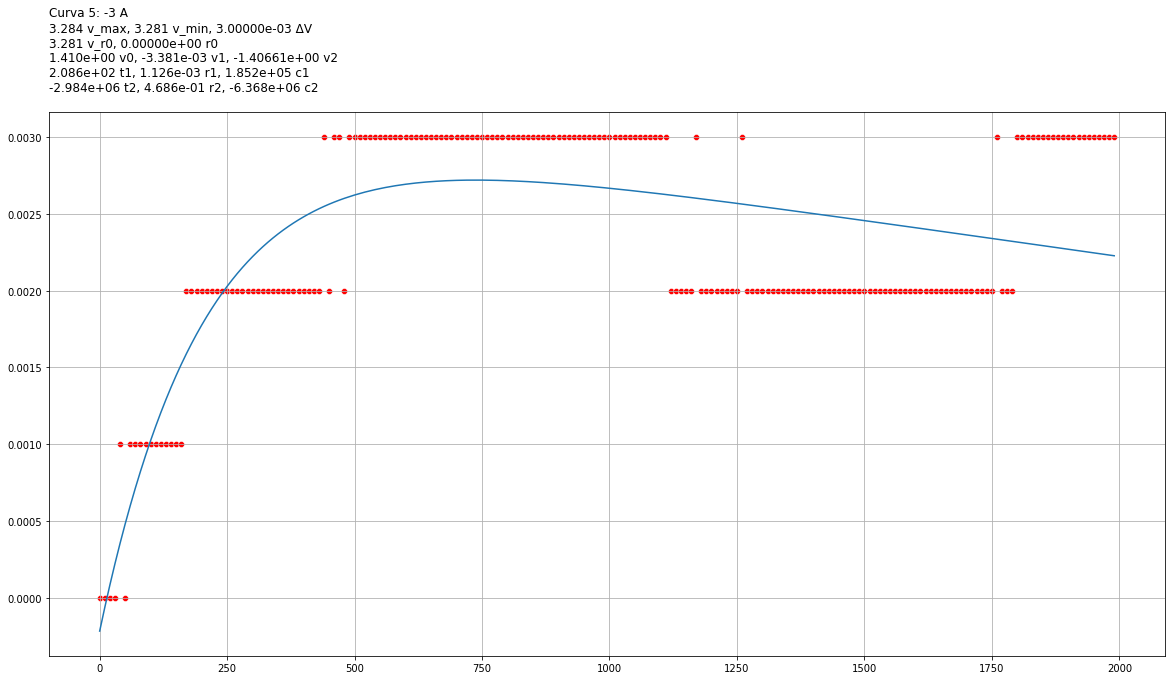

/tmp/ipykernel_1687/2759462548.py:2: RuntimeWarning: overflow encountered in exp
  return v0+v1*np.exp(-t*t1)+v2*np.exp(-t*t2)


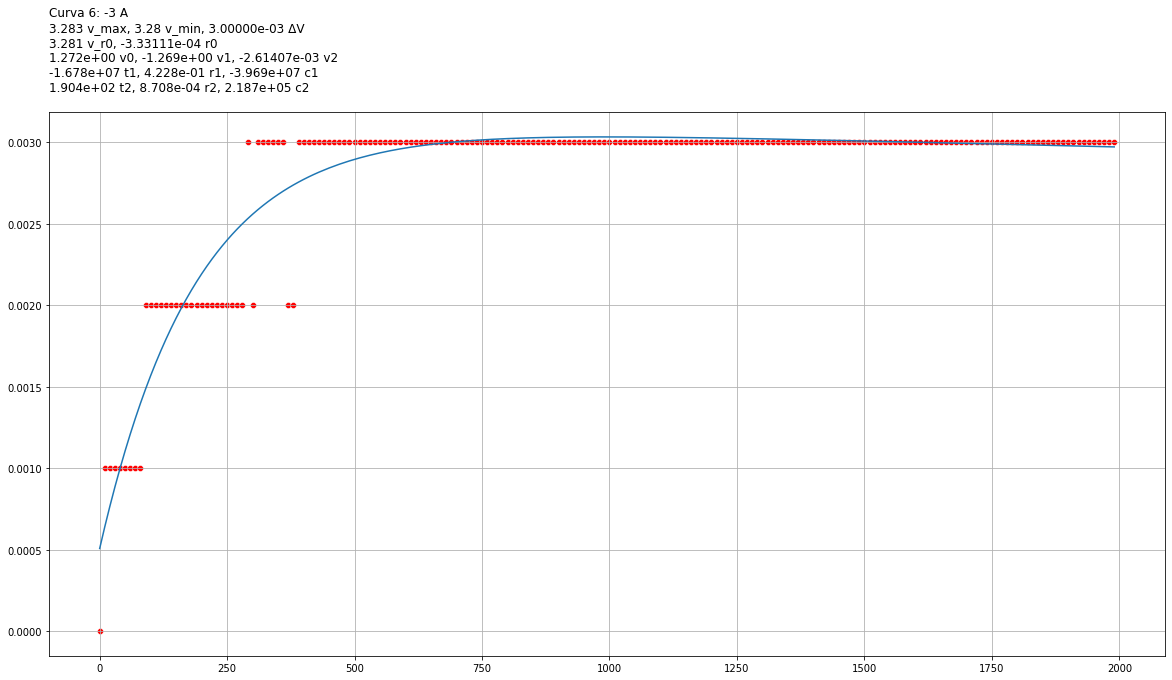

/tmp/ipykernel_1687/2759462548.py:2: RuntimeWarning: overflow encountered in exp
  return v0+v1*np.exp(-t*t1)+v2*np.exp(-t*t2)


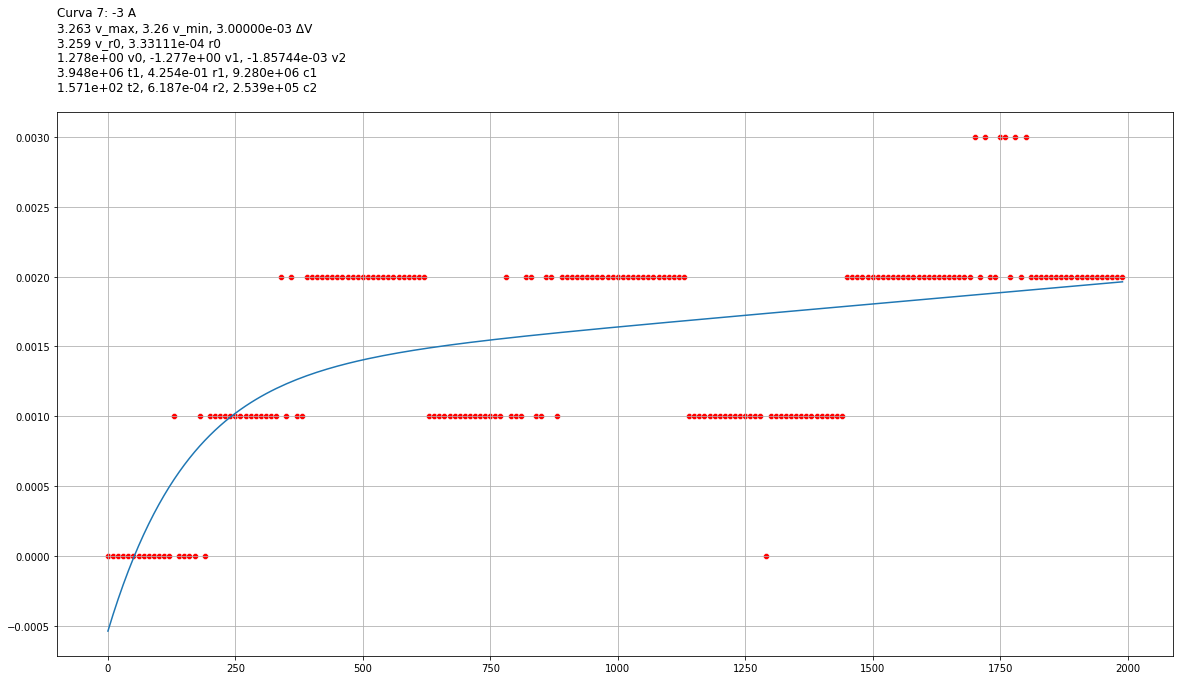

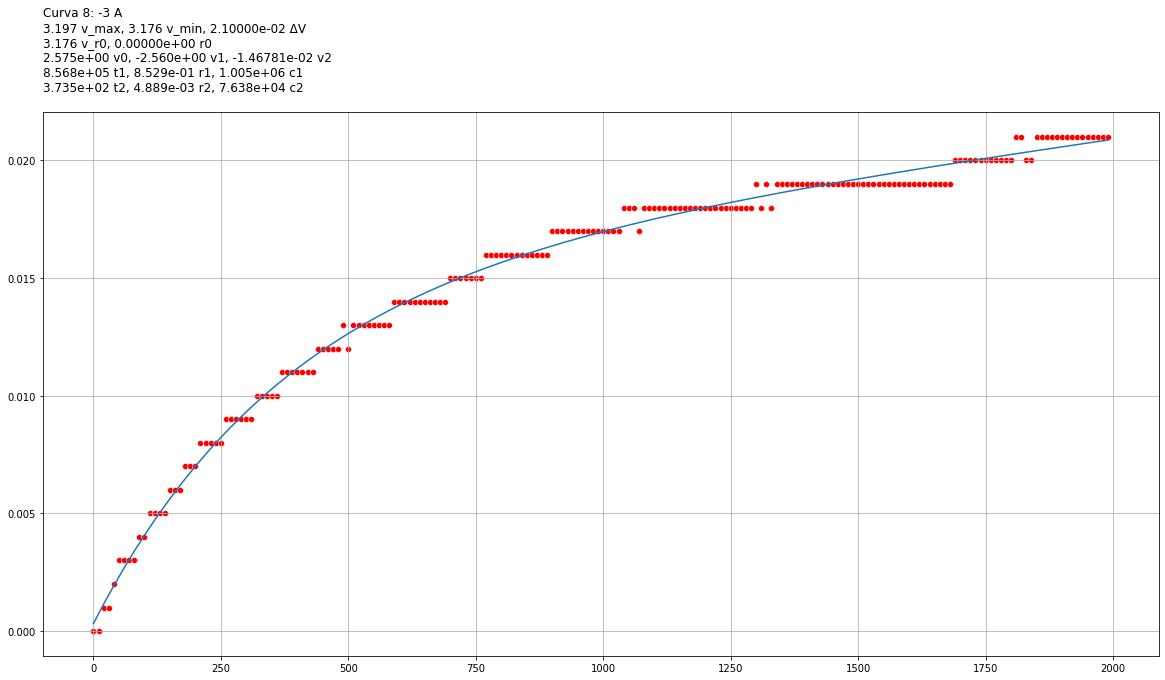

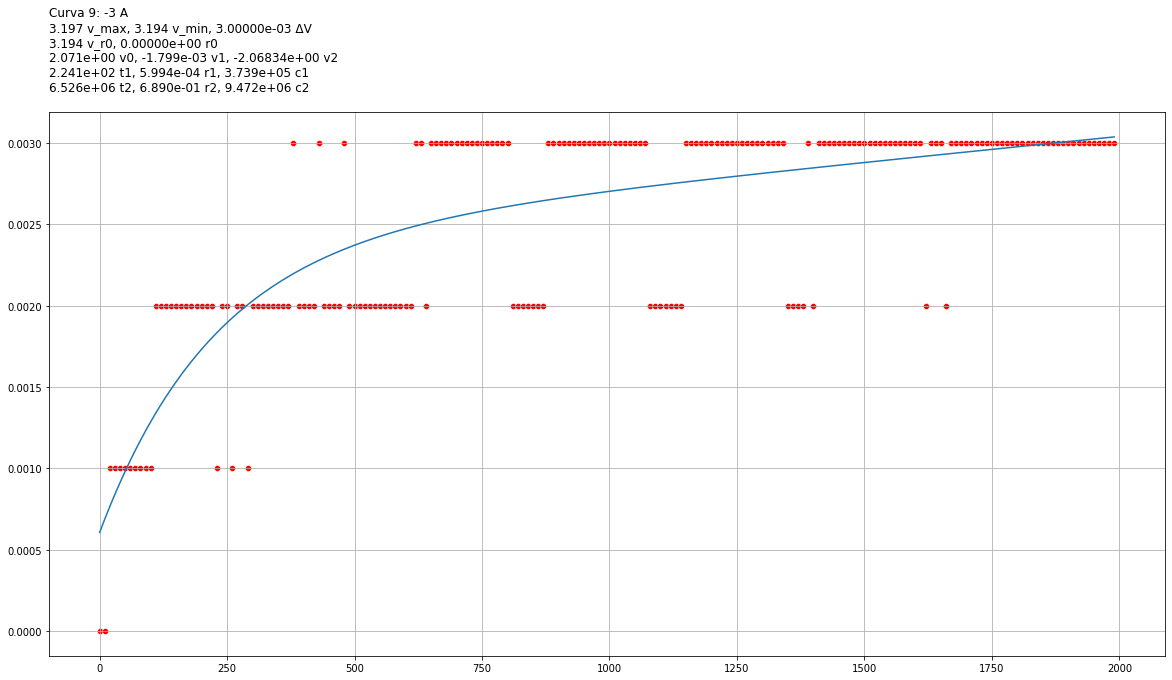

In [7]:
I = "3A"
coeficientes = gerar_coeficientes_e_graficos(
    points, I, bounds, coeficientes, p0, df_c100
)
